In [147]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage.draw import polygon2mask
from scipy import ndimage
from PIL import Image
from preprocessing import biasCorrect
from skimage.color import label2rgb
from skimage.morphology import label
from IPython.display import display, clear_output
from skimage.measure import regionprops

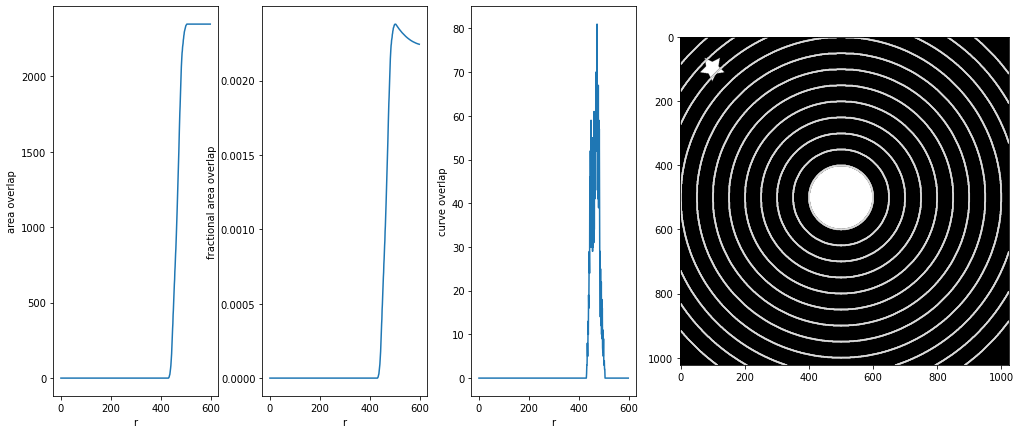

In [148]:
t = np.linspace(0,2*np.pi,11)   

canvas = np.zeros((1024,1024))
a = 0.5
xs = np.array([np.cos(t[0:-2:2]), a*np.cos(t[1:-1:2])])
ys = np.array([np.sin(t[0:-2:2]), a*np.sin(t[1:-1:2])])
star = np.array([np.concatenate(xs.T), np.concatenate(ys.T)]).T

t = np.linspace(0,2*np.pi,1000)
circle = np.array([np.cos(t), np.sin(t)]).T

star_mask = polygon2mask((1024,1024), (star*40) + 100)
circle_mask = polygon2mask((1024,1024), (circle*100) + 500)
all_mask = star_mask + circle_mask

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()
ax[3].imshow(all_mask)

D = ndimage.distance_transform_edt(circle_mask==0)
r_max = 600
f = np.zeros(r_max)
g = np.zeros(r_max)
for i in range(0,r_max):
    K = D<=i
    f[i] = np.count_nonzero(K*star_mask)
    g[i] = np.count_nonzero(K)
    if (i%50==0):
        ax[3].contour(K)
        display(fig)
        clear_output(wait = True)
        

ax[0].plot(f)
ax[0].set_xlabel('r')
ax[0].set_ylabel('area overlap')

ax[1].plot(f/g)
ax[1].set_xlabel('r')
ax[1].set_ylabel('fractional area overlap')

ax[2].plot(f[1:]-f[:-1])
ax[2].set_xlabel('r')
ax[2].set_ylabel('curve overlap')

plt.show()

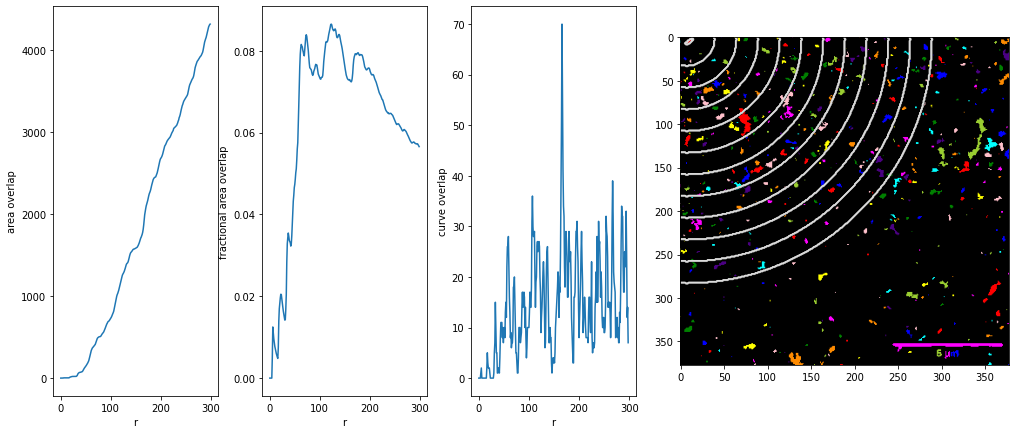

In [149]:
path = 'images/1carr-96etoh-alexa-sted-decon.tif'
img = Image.open(path).convert("L")
image = np.array(img)
threshold_value = 90
bw = image > threshold_value
label_image = label(bw)
#label_image = biasCorrect()

L = 100 # Maximum distances to consider
M = label_image.shape[0] - L

label_image_bounded = np.zeros(label_image.shape, dtype=int)
regions = regionprops(label_image)
cluster_num = 1
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    if (minr > L+1) & (minc > L+1) & (maxr < M+1) & (maxc < M+1):
        pixel_coordinates = props.coords
        label_image_bounded[pixel_coordinates[:,0],  pixel_coordinates[:,1]] =  cluster_num
        cluster_num += 1

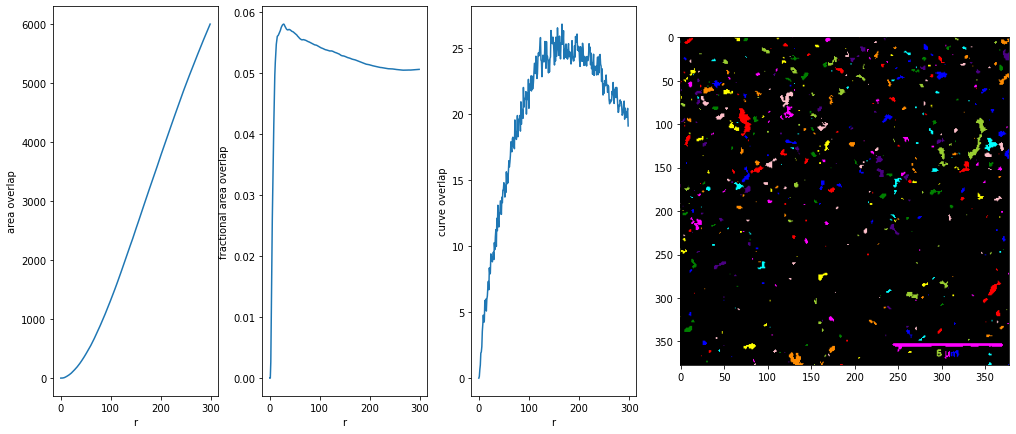

In [150]:
fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()

bx = (L, M, M, L, L)
by = (L, L, M, M, L)
ax[3].plot(bx, by, '-r')
ax[3].imshow(label2rgb(label_image, bg_label=0))

ref_cluster = label_image_bounded == 1

rem_clusters = label_image * np.invert(ref_cluster)


D = ndimage.distance_transform_edt(ref_cluster==0)
f = np.zeros(L+1)
g = np.zeros(L+1)
for i in range(0,L+1):
    K = D<=i
    f[i] = np.count_nonzero(K*rem_clusters)
    g[i] = np.count_nonzero(K)
    if (i%10==0):
        ax[3].contour(K)
        display(fig)
        clear_output(wait = True)
        

ax[0].plot(f)
ax[0].set_xlabel('r')
ax[0].set_ylabel('area overlap')

ax[1].plot(f/g)
ax[1].set_xlabel('r')
ax[1].set_ylabel('fractional area overlap')

ax[2].plot(f[1:]-f[:-1])
ax[2].set_xlabel('r')
ax[2].set_ylabel('curve overlap')

plt.show()

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()

bx = (L, M, M, L, L)
by = (L, L, M, M, L)
ax[3].plot(bx, by, '-r')
ax[3].imshow(label2rgb(label_image, bg_label=0))
curr_image = label_image_bounded

F = np.zeros(L+1)
G = np.zeros(L+1)
for cluster in range (1, curr_image.max()+1):
    ref_cluster = curr_image == cluster
    rem_clusters = label_image * np.invert(ref_cluster)
    
    D = ndimage.distance_transform_edt(ref_cluster==0)
    f = np.zeros(L+1)
    g = np.zeros(L+1)
    for i in range(0,L+1):
        K = D<=i
        f[i] = np.count_nonzero(K*rem_clusters)
        g[i] = np.count_nonzero(K)
    F += f
    G += g

F = F / curr_image.max()
G = G / curr_image.max()

ax[0].plot(F)
ax[0].set_xlabel('r')
ax[0].set_ylabel('area overlap')

ax[1].plot(F/G)
ax[1].set_xlabel('r')
ax[1].set_ylabel('fractional area overlap')

ax[2].plot(F[1:]-F[:-1])
ax[2].set_xlabel('r')
ax[2].set_ylabel('curve overlap')
plt.show()

In [ ]:
print(np.argmax((F/G)[0:25]))